## Model Development

Based on the previous work in the other notebooks, we managed to gain some initial insight for what might be contributing features when it comes to determining an online users MBTI personality factors based on what they posted, such as the overall sentiment of their posts, length of their posts, noun and verb frequency of their posts, etc. Here we try to develop a model with more emphasis on performance.

### SMOTE + Word2Vec + Logistic Regression

In the paper *Ryan, G.; Katarina, P.; Suhartono, D. MBTI Personality Prediction Using Machine Learning and SMOTE for Balancing Data Based on Statement Sentences. Information 2023, 14, 217*, a combination of SMOTE oversampling, Word2Vec word embeddings and Logistic Regression was used to achieve an average F1 - Score of 0.8337 across the four dimensions of MBTI personalities, namely:
- Extraversion vs Introversion
- Sensing vs Intuition
- Thinking vs Feeling
- Judgment vs Perception

In this section we will attempt to implement this model from the paper using their methodology.

##### Preprocess Dataset

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import nltk
from itertools import zip_longest
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words('english'))

In [ ]:
CSV_DATA_PATH = os.path.join("data", "mbti_1.csv")

def load_csv_data(csv_file_path: str):
    """ Load data from a given csv file into a pandas DataFrame object.

    Args:
    - csv_file_path (str) - The file path of the csv file containing the desired data to load into a pandas DataFrame object.

    Returns:
    - data (pandas.DataFrame) - The loaded data as a pandas DataFrame object.
    """
    assert csv_file_path.endswith(".csv")

    return pd.read_csv(csv_file_path)

def get_online_posts_df(df: pd.DataFrame, type_col: str = "type", posts_col: str = "posts"):
    """ Takes in an input pandas DataFrame, each row having a (user_personality_type, user_recent_50_comments) schema and user_recent_50_comments is a '|||' delimited string.
    Outputs a DataFrame object where each row is a (user_personality_type, user_comment), where each row no contains exactly one comment.

    Args:
    - df (pandas.DataFrame) - The input pandas DataFrame object, where each row follows the schema (user_personality_type, user_recent_50_comments).
    - type_col (str) - The column name of the input DataFrame's personality type column, which contains the user's personality type.
    - posts_col (str) - The column name of the input DataFrame's posts column, which contains the user's recent 50 comments/online posts

    Returns:
    - output_df (pandas.DataFrame) - The output pandas DataFrame object, where each row follows the schema (user_personality_type, user_comment).
    """
    online_posts_dict = {
        type_col: [],
        posts_col: []
    }

    for index, row in df.iterrows():
        personality_type = row[type_col]
        recent_50_comments = row[posts_col].split("|||")

        online_posts_dict[type_col] += [personality_type] * len(recent_50_comments)
        online_posts_dict[posts_col] += recent_50_comments

    columns = online_posts_dict.keys()
    values = list(zip_longest(*online_posts_dict.values()))
    output_df = pd.DataFrame(values, columns=columns)

    return output_df

def get_personality_dimensions(personality_dataset: pd.DataFrame, personalities_col_name: str = "type"):
    """ Return a dictionary containing the personality dimensions from the given pandas DataFrame containing Myers Briggs personalities.

    Args:
    - personality_dataset (pandas.DataFrame) - The pandas DataFrame object containing the Myers Briggs personalities data.
    - personalities_col_name (str) - The name of the column which contains the Myers Briggs personalities in the given DataFrame.

    Returns:
    - personality_factors_dict (dict) - A dictionary containing the number personality dimensions, split into Extraversion vs Introversion, Sensing vs Intuition, Thinking vs Feeling, Judging vs Perceiving.
    """
    personality_factors_dict = {
        "e_vs_i": [],
        "s_vs_n": [],
        "t_vs_f": [],
        "j_vs_p": []
    }

    for index, row in personality_dataset.iterrows():
        personality_type_str = row[personalities_col_name]
        e_vs_i = personality_type_str[0]
        s_vs_n = personality_type_str[1]
        t_vs_f = personality_type_str[2]
        j_vs_p = personality_type_str[3]

        personality_factors_dict["e_vs_i"].append(e_vs_i)
        personality_factors_dict["s_vs_n"].append(s_vs_n)
        personality_factors_dict["t_vs_f"].append(t_vs_f)
        personality_factors_dict["j_vs_p"].append(j_vs_p)

    return personality_factors_dict  

def preprocess_df(df: pd.DataFrame):
    """ Helper function for preprocessing the input pandas dataframe by helping clean up input user posts.

    Args:
    - df (pd.DataFrame) - The input dataframe object containing the user posts to clean up.

    Returns:
    - df (pd.DataFrame) - The given dataframe object after cleaning has been applied to the user posts data.
    """   

    # Make each data record a user post rather than a user's top 50 posts.
    df = get_online_posts_df(df)

    # Extract the labels across the four dimensions of MBTI personalities corresponding to each post
    personality_factors_per_post_dict = get_personality_dimensions(df)
    columns = personality_factors_per_post_dict.keys()
    values = list(zip_longest(*personality_factors_per_post_dict.values()))
    personality_factors_per_post = pd.DataFrame(values, columns=columns)
    df = pd.concat([personality_factors_per_post, df], axis=1)

    # Remove urls
    regex_pattern = r"((?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])))"
    df["posts_no_url"] = df["posts"].str.replace(regex_pattern, "").str.strip()

    # Keep the End Of Sentence characters
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', str(x) + " "))
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', str(x) + " "))
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', str(x) + " "))
    
    # Strip Punctation
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'[\.+]', ".", str(x)))

    # Remove multiple fullstops
    # df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'[^\w\s]','', str(x)))

    # Remove Non-words
    # df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','', str(x)))

    # Convert posts to lowercase
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: str(x).lower())

    # Remove multiple letter repeating words
    # df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','', str(x)))
    
    # Strip trailing whitespaces
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: str(x).strip())

    # Remove rows with no text
    df["posts_no_url"] = df["posts_no_url"].replace('', np.nan)
    df["posts_no_url"] = df["posts_no_url"].replace('nan', np.nan)
    df["posts_no_url"] = df["posts_no_url"].replace("'", np.nan)
    df["posts_no_url"] = df["posts_no_url"].replace("''", np.nan)
    df["posts_no_url"] = df["posts_no_url"].replace('"', np.nan)
    df["posts_no_url"] = df["posts_no_url"].replace('""', np.nan)
    df.dropna(subset=["posts_no_url"], inplace=True)

    # Tokenize posts
    df["posts_no_url_tokens"] = df["posts_no_url"].apply(wordpunct_tokenize)

    # Remove stop words
    df["posts_no_url_tokens_no_stop"] = df["posts_no_url_tokens"].apply(lambda x: [token for token in x if token not in stop_words])

    # Lemmatize posts
    lemmatizer = WordNetLemmatizer()
    df["posts_no_url_tokens_no_stop"] = df["posts_no_url_tokens_no_stop"].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

    return df[["e_vs_i", "s_vs_n", "t_vs_f", "j_vs_p", "type", "posts", "posts_no_url", "posts_no_url_tokens_no_stop"]]

def binarize_targets(df: pd.DataFrame):
    """ Apply 0/1 labels to the input classes in the df.

    Args:
    - df (pd.DataFrame) - The input dataframe object containing the classes to numerically label.

    Returns:
    - df (pd.DataFrame) - The given dataframe object after numerically labelling classes.
    """
    binary_map = {
        'I': 0, 
        'E': 1, 
        'N': 0, 
        'S': 1, 
        'F': 0, 
        'T': 1, 
        'J': 0, 
        'P': 1
    }

    df["EI"] = df["e_vs_i"].apply(lambda x: binary_map[str(x)])
    df["SN"] = df["s_vs_n"].apply(lambda x: binary_map[str(x)])
    df["TF"] = df["t_vs_f"].apply(lambda x: binary_map[str(x)])
    df["JP"] = df["j_vs_p"].apply(lambda x: binary_map[str(x)])

    df["target_vec"] = df.apply(lambda x: [
        x["EI"],
        x["SN"],
        x["TF"],
        x["JP"]
    ], axis=1)

    return df

def preprocess_dataset(csv_file_path: str = CSV_DATA_PATH):
    """ Load and preprocess data to be used for model development.

    Args:
    - csv_file_path (str) - The file path of the csv file containing the desired data to load into a pandas DataFrame object.

    Returns:
    - numpy arrays of training and test split data.
    """

    # Apply preprocessing to input user posts
    df = load_csv_data(csv_file_path)
    df = preprocess_df(df)

    # Preprocess target labels into a binary vector
    df = binarize_targets(df)

    return df

In [ ]:
df = preprocess_dataset()
df.head()

The following preprocessing steps were applied to the dataset:
- Converting letters to lowercase
- Removing links
- Removing punctuations
- Removing stopwords

Lematization was also applied after the above steps have been conducted, and the resulting text for each post tokenized.

##### Word Embeddings and Text Vectorization

In [ ]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

In [ ]:
# Train Word2Vec model
w2w_model = Word2Vec(sentences=df["posts_no_url_tokens_no_stop"], vector_size=500, window=5, min_count=5, epochs=50)

def get_train_test_split(training_fraction: float, df: pd.DataFrame, mbti_dim: str):
    """ Get a training and test dataset split.

    Args:
    - training_proportion (float) - The fraction of the dataset to be used as training data.
    - df (pd.DataFrame) - The pandas dataframe object containing the data to be split into train and test sets.
    - mbti_dim (str) - The column name of the target MBTI personality dimension.

    Returns:
    - Train and test datasets where the target variable is the desired MBTI personality dimension (mbti_dim).
    """

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(df["posts_no_url_tokens_no_stop"], df[mbti_dim], test_size=(1 - training_fraction), random_state=42)

    X_train = np.array([vectorize(post) for post in X_train])
    X_test = np.array([vectorize(post) for post in X_test])

    return X_train, X_test, y_train, y_test

def vectorize(post: list):
    """ Vectorize a sentence to a vector representation using Word2Vec CBOW.

    Args:
    - post (str) - A post to vectorize. Here, the post is passed into the function as a list of word tokens.

    Returns:
    - Word2Vec word embedding (CBOW).
    """

    # Vectorize sentence
    words_vector = [w2w_model.wv[token] for token in post if token in w2w_model.wv]

    if len(words_vector) == 0:
        return np.zeros(500)
    
    words_vector = np.array(words_vector)
    return words_vector.mean(axis=0)

In [ ]:
X_train_EI, X_test_EI, y_train_EI, y_test_EI = get_train_test_split(0.7, df, "EI") 
print(X_train_EI)

In [ ]:
print(X_test_EI[160])
print(type(X_test_EI))

Here we create functionality that can split out user posts dataset into train and test sets, and vectorize the text data to be used as model inputs as Word2Vec word embeddings. The benefit with using word embeddings is that we can represent words in a numerical format (ML/DL models can only take in numerical input) that allows words with similar meanings to have the same representation, i.e. smilarity of meaning between words is captured in the word embeddings.

##### Training

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import LearningCurveDisplay

In [ ]:
def model_LR():
    """ Create a simple Logistic Regression model on the given training data. 
    SMOTE oversampling will also performed when this model is fitted to training data.

    Args:
    - X (iterable) - Input training examples.
    - y (iterable) - Training target labels.

    Returns:
    - The Logistic Regression model to be fitted onto training data.
    """

    # Instatiate SMOTE over-sampler and Logistic Regression model.
    sampler = SMOTE(random_state=42)
    lr = LogisticRegression(
        penalty=None,
        max_iter=1000,
        n_jobs=-1,
        random_state=42
    )

    # Build pipeline/model.
    pipeline = Pipeline([
        ("sampler", sampler),
        ("lr", lr)
    ])

    return pipeline

def train_model(X, y, model):
    """ Train the input model on the given training data.

    Args:
    - X (iterable) - Input training examples.
    - y (iterable) - Training target labels.
    - model - The model to be fitted onto the training data.

    Returns:
    - The model fitted to the training data.
    """
    model.fit(X, y)

    return model

def evaluate(X, y, model, target_names):
    """ Evaluate the given trained model on the test data.

    Args:
    - X (iterable) - Input test examples.
    - y (iterable) - Test target labels.
    - target_names - The names of the labels for the classfication report.

    Returns:
    - None
    """
    y_pred = model.predict(X)
    print(classification_report(y, y_pred, target_names=target_names)) 

In [ ]:
# Split data into train and test sets for each MBTI dimension.
X_train_EI, X_test_EI, y_train_EI, y_test_EI = get_train_test_split(0.7, df, "EI")
X_train_SN, X_test_SN, y_train_SN, y_test_SN = get_train_test_split(0.7, df, "SN")
X_train_TF, X_test_TF, y_train_TF, y_test_TF = get_train_test_split(0.7, df, "TF") 
X_train_JP, X_test_JP, y_train_JP, y_test_JP = get_train_test_split(0.7, df, "JP")

# Create Logistic Regression classifiers for each MBTI dimension.
ei_classifier = model_LR()
sn_classifier = model_LR()
tf_classifier = model_LR()
jp_classifier = model_LR()

# Train classifiers.
ei_classifier = train_model(X_train_EI, y_train_EI, ei_classifier)
sn_classifier = train_model(X_train_SN, y_train_SN, sn_classifier)
tf_classifier = train_model(X_train_TF, y_train_TF, tf_classifier)
jp_classifier = train_model(X_train_JP, y_train_JP, jp_classifier)

In [ ]:
# Evaluate Extraversion vs Introversion classifier.
evaluate(X_test_EI, y_test_EI, ei_classifier, ["Introversion", "Extraversion"])

In [ ]:
# Evaluate Sensing vs Intuition classifier.
evaluate(X_test_SN, y_test_SN, sn_classifier, ["Intuition", "Sensing"])

In [ ]:
# Evaluate Thinking vs Feeling classifier.
evaluate(X_test_TF, y_test_TF, tf_classifier, ["Feeling", "Thinking"])

In [ ]:
# Evaluate Judging vs Perceiving classifier.
evaluate(X_test_JP, y_test_JP, jp_classifier, ["Judging", "Perceiving"])

In [ ]:
# Learning cruves for the classifiers.
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.flatten()

# Extraversion vs Introversion.
X_EI = np.concatenate((X_train_EI, X_test_EI), axis=0)
y_EI = np.concatenate((y_train_EI, y_test_EI), axis=0)
model0 = model_LR()
LearningCurveDisplay.from_estimator(model0, X_EI, y_EI, scoring="f1_macro", score_name="F1 Macro Avg", score_type="both", n_jobs=4, line_kw={"marker": "o"}, random_state=42, ax=ax[0])
handles0, label0 = ax[0].get_legend_handles_labels()
ax[0].legend(handles0[:2], ["Training Score", "Test Score"])
ax[0].set_title("Extraversion vs Introversion")

# Sensing vs Intuition.
X_SN = np.concatenate((X_train_SN, X_test_SN), axis=0)
y_SN = np.concatenate((y_train_SN, y_test_SN), axis=0)
model1 = model_LR()
LearningCurveDisplay.from_estimator(model1, X_SN, y_SN, scoring="f1_macro", score_name="F1 Macro Avg", score_type="both", n_jobs=4, line_kw={"marker": "o"}, random_state=42, ax=ax[1])
handles1, label1 = ax[1].get_legend_handles_labels()
ax[1].legend(handles1[:2], ["Training Score", "Test Score"])
ax[1].set_title("Sensing vs Intuition")

# Thinking vs Feeling.
X_TF = np.concatenate((X_train_TF, X_test_TF), axis=0)
y_TF = np.concatenate((y_train_TF, y_test_TF), axis=0)
model2 = model_LR()
LearningCurveDisplay.from_estimator(model2, X_TF, y_TF, scoring="f1_macro", score_name="F1 Macro Avg", score_type="both", n_jobs=4, line_kw={"marker": "o"}, random_state=42, ax=ax[2])
handles2, label2 = ax[2].get_legend_handles_labels()
ax[2].legend(handles2[:2], ["Training Score", "Test Score"])
ax[2].set_title("Thinking vs Feeling")

# Judging vs Perceiving.
X_JP = np.concatenate((X_train_JP, X_test_JP), axis=0)
y_JP = np.concatenate((y_train_JP, y_test_JP), axis=0)
model3 = model_LR()
LearningCurveDisplay.from_estimator(model3, X_JP, y_JP, scoring="f1_macro", score_name="F1 Macro Avg", score_type="both", n_jobs=4, line_kw={"marker": "o"}, random_state=42, ax=ax[3])
handles3, label3 = ax[3].get_legend_handles_labels()
ax[3].legend(handles3[:2], ["Training Score", "Test Score"])
ax[3].set_title("Judging vs Perceiving")

fig.suptitle("Learning Curves")
plt.show()

From the classification reports we see that using the default parameter settings for logistic regression classifiers gives us an macro average F1 score in the 50s across the four dimensions of mbti personality. The learning curves above also show that overfitting might is not that big given the volume of posts we have in our dataset, however, it could also be the default L2 regularisation parameter of 10 in sklearn's Logistic Regression object.

Now we will try to experiment with some different parameter settings to see if we can improve performance (with respect to macro average F1) and see if we can get closer to the performance acheived in the paper *Ryan, G.; Katarina, P.; Suhartono, D. MBTI Personality Prediction Using Machine Learning and SMOTE for Balancing Data Based on Statement Sentences. Information 2023, 14, 217*.

In [ ]:
def model_LR_CV():
    """ Create Logistic Regression model on the given training data. 
    
    Cross Validation will be used to tune the hyperparameters of the model and SMOTE oversampling will also performed when this model is fitted to training data.

    Args:
    - X (iterable) - Input training examples.
    - y (iterable) - Training target labels.

    Returns:
    - The Logistic Regression model to be fitted onto training data.
    """

    # Instatiate SMOTE over-sampler and Logistic Regression model.
    sampler = SMOTE(random_state=42)
    lr = LogisticRegressionCV(
        Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        scoring="f1_macro",
        n_jobs=-1,
        max_iter=1000,
        random_state=42
    )

    # Build pipeline/model.
    pipeline = Pipeline([
        ("sampler", sampler),
        ("lr", lr)
    ])

    return pipeline

In [ ]:
# Split data into train and test sets for each MBTI dimension.
X_train_EI, X_test_EI, y_train_EI, y_test_EI = get_train_test_split(0.7, df, "EI")
X_train_SN, X_test_SN, y_train_SN, y_test_SN = get_train_test_split(0.7, df, "SN")
X_train_TF, X_test_TF, y_train_TF, y_test_TF = get_train_test_split(0.7, df, "TF") 
X_train_JP, X_test_JP, y_train_JP, y_test_JP = get_train_test_split(0.7, df, "JP")

# Create Logistic Regression classifiers for each MBTI dimension.
ei_classifier = model_LR_CV()
sn_classifier = model_LR_CV()
tf_classifier = model_LR_CV()
jp_classifier = model_LR_CV()

# Train classifiers.
ei_classifier = train_model(X_train_EI, y_train_EI, ei_classifier)
sn_classifier = train_model(X_train_SN, y_train_SN, sn_classifier)
tf_classifier = train_model(X_train_TF, y_train_TF, tf_classifier)
jp_classifier = train_model(X_train_JP, y_train_JP, jp_classifier)

In [ ]:
# Evaluate Extraversion vs Introversion classifier.
evaluate(X_test_EI, y_test_EI, ei_classifier, ["Introversion", "Extraversion"])

In [ ]:
# Evaluate Sensing vs Intuition classifier.
evaluate(X_test_SN, y_test_SN, sn_classifier, ["Intuition", "Sensing"])

In [ ]:
# Evaluate Thinking vs Feeling classifier.
evaluate(X_test_TF, y_test_TF, tf_classifier, ["Feeling", "Thinking"])

In [ ]:
# Evaluate Judging vs Perceiving classifier.
evaluate(X_test_JP, y_test_JP, jp_classifier, ["Judging", "Perceiving"])

In [ ]:
# Learning cruves for the classifiers.
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.flatten()

# Extraversion vs Introversion.
X_EI = np.concatenate((X_train_EI, X_test_EI), axis=0)
y_EI = np.concatenate((y_train_EI, y_test_EI), axis=0)
model0 = model_LR()
LearningCurveDisplay.from_estimator(model0, X_EI, y_EI, scoring="f1_macro", score_name="F1 Macro Avg", score_type="both", n_jobs=4, line_kw={"marker": "o"}, random_state=42, ax=ax[0])
handles0, label0 = ax[0].get_legend_handles_labels()
ax[0].legend(handles0[:2], ["Training Score", "Test Score"])
ax[0].set_title("Extraversion vs Introversion")

# Sensing vs Intuition.
X_SN = np.concatenate((X_train_SN, X_test_SN), axis=0)
y_SN = np.concatenate((y_train_SN, y_test_SN), axis=0)
model1 = model_LR()
LearningCurveDisplay.from_estimator(model1, X_SN, y_SN, scoring="f1_macro", score_name="F1 Macro Avg", score_type="both", n_jobs=4, line_kw={"marker": "o"}, random_state=42, ax=ax[1])
handles1, label1 = ax[1].get_legend_handles_labels()
ax[1].legend(handles1[:2], ["Training Score", "Test Score"])
ax[1].set_title("Sensing vs Intuition")

# Thinking vs Feeling.
X_TF = np.concatenate((X_train_TF, X_test_TF), axis=0)
y_TF = np.concatenate((y_train_TF, y_test_TF), axis=0)
model2 = model_LR()
LearningCurveDisplay.from_estimator(model2, X_TF, y_TF, scoring="f1_macro", score_name="F1 Macro Avg", score_type="both", n_jobs=4, line_kw={"marker": "o"}, random_state=42, ax=ax[2])
handles2, label2 = ax[2].get_legend_handles_labels()
ax[2].legend(handles2[:2], ["Training Score", "Test Score"])
ax[2].set_title("Thinking vs Feeling")

# Judging vs Perceiving.
X_JP = np.concatenate((X_train_JP, X_test_JP), axis=0)
y_JP = np.concatenate((y_train_JP, y_test_JP), axis=0)
model3 = model_LR()
LearningCurveDisplay.from_estimator(model3, X_JP, y_JP, scoring="f1_macro", score_name="F1 Macro Avg", score_type="both", n_jobs=4, line_kw={"marker": "o"}, random_state=42, ax=ax[3])
handles3, label3 = ax[3].get_legend_handles_labels()
ax[3].legend(handles3[:2], ["Training Score", "Test Score"])
ax[3].set_title("Judging vs Perceiving")

fig.suptitle("Learning Curves")
plt.show()

### Deep Neural Network

In the paper *Sakdipat Ontoum, Jonathan H. Chan. Personality Type Based on Myers-Briggs Type Indicator with Text Posting Style by using Traditional and Deep Learning. https://doi.org/10.48550/arXiv.2201.08717*, they acheived a macro average F1 score of 80+ across the following MBTI dimensions using a deep neural network:
- Extraversion vs Introversion
- Sensing vs Intuition
- Thinking vs Feeling
- Judgment vs Perception

In this section we will attempt to implement this model from the paper and see if we can achieve better results than the model used in the feature engineering notebook.

##### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import os
import re
import nltk
from itertools import zip_longest
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
CSV_DATA_PATH = os.path.join("data", "mbti_1.csv")

def load_csv_data(csv_file_path: str):
    """ Load data from a given csv file into a pandas DataFrame object.

    Args:
    - csv_file_path (str) - The file path of the csv file containing the desired data to load into a pandas DataFrame object.

    Returns:
    - data (pandas.DataFrame) - The loaded data as a pandas DataFrame object.
    """
    assert csv_file_path.endswith(".csv")

    return pd.read_csv(csv_file_path)

def get_online_posts_df(df: pd.DataFrame, type_col: str = "type", posts_col: str = "posts"):
    """ Takes in an input pandas DataFrame, each row having a (user_personality_type, user_recent_50_comments) schema and user_recent_50_comments is a '|||' delimited string.
    Outputs a DataFrame object where each row is a (user_personality_type, user_comment), where each row no contains exactly one comment.

    Args:
    - df (pandas.DataFrame) - The input pandas DataFrame object, where each row follows the schema (user_personality_type, user_recent_50_comments).
    - type_col (str) - The column name of the input DataFrame's personality type column, which contains the user's personality type.
    - posts_col (str) - The column name of the input DataFrame's posts column, which contains the user's recent 50 comments/online posts

    Returns:
    - output_df (pandas.DataFrame) - The output pandas DataFrame object, where each row follows the schema (user_personality_type, user_comment).
    """
    online_posts_dict = {
        type_col: [],
        posts_col: []
    }

    for index, row in df.iterrows():
        personality_type = row[type_col]
        recent_50_comments = row[posts_col].split("|||")

        online_posts_dict[type_col] += [personality_type] * len(recent_50_comments)
        online_posts_dict[posts_col] += recent_50_comments

    columns = online_posts_dict.keys()
    values = list(zip_longest(*online_posts_dict.values()))
    output_df = pd.DataFrame(values, columns=columns)

    return output_df

def get_personality_dimensions(personality_dataset: pd.DataFrame, personalities_col_name: str = "type"):
    """ Return a dictionary containing the personality dimensions from the given pandas DataFrame containing Myers Briggs personalities.

    Args:
    - personality_dataset (pandas.DataFrame) - The pandas DataFrame object containing the Myers Briggs personalities data.
    - personalities_col_name (str) - The name of the column which contains the Myers Briggs personalities in the given DataFrame.

    Returns:
    - personality_factors_dict (dict) - A dictionary containing the number personality dimensions, split into Extraversion vs Introversion, Sensing vs Intuition, Thinking vs Feeling, Judging vs Perceiving.
    """
    personality_factors_dict = {
        "e_vs_i": [],
        "s_vs_n": [],
        "t_vs_f": [],
        "j_vs_p": []
    }

    for index, row in personality_dataset.iterrows():
        personality_type_str = row[personalities_col_name]
        e_vs_i = personality_type_str[0]
        s_vs_n = personality_type_str[1]
        t_vs_f = personality_type_str[2]
        j_vs_p = personality_type_str[3]

        personality_factors_dict["e_vs_i"].append(e_vs_i)
        personality_factors_dict["s_vs_n"].append(s_vs_n)
        personality_factors_dict["t_vs_f"].append(t_vs_f)
        personality_factors_dict["j_vs_p"].append(j_vs_p)

    return personality_factors_dict  

def preprocess_df(df: pd.DataFrame):
    """ Helper function for preprocessing the input pandas dataframe by helping clean up input user posts.

    Args:
    - df (pd.DataFrame) - The input dataframe object containing the user posts to clean up.

    Returns:
    - df (pd.DataFrame) - The given dataframe object after cleaning has been applied to the user posts data.
    """   

    # Make each data record a user post rather than a user's top 50 posts.
    df = get_online_posts_df(df)

    # Extract the labels across the four dimensions of MBTI personalities corresponding to each post
    personality_factors_per_post_dict = get_personality_dimensions(df)
    columns = personality_factors_per_post_dict.keys()
    values = list(zip_longest(*personality_factors_per_post_dict.values()))
    personality_factors_per_post = pd.DataFrame(values, columns=columns)
    df = pd.concat([personality_factors_per_post, df], axis=1)

    # Remove urls
    regex_pattern = r"((?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])))"
    df["posts_no_url"] = df["posts"].str.replace(regex_pattern, "").str.strip()

    # Keep the End Of Sentence characters
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', str(x) + " "))
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', str(x) + " "))
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', str(x) + " "))

    # Strip trailing whitespaces
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: str(x).strip())

    # Tokenize posts
    df["posts_no_url_tokens"] = df["posts_no_url"].apply(word_tokenize)

    # Remove stop words
    df["posts_no_url_tokens_no_stop"] = df["posts_no_url_tokens"].apply(lambda x: [token for token in x if token not in stop_words])

    # Lemmatize posts
    lemmatizer = WordNetLemmatizer()
    df["posts_no_url_tokens_no_stop"] = df["posts_no_url_tokens_no_stop"].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

    # Remove rows with no text
    df["posts_no_url"] = df["posts_no_url"].replace('nan', np.nan)
    df["posts_no_url"] = df["posts_no_url"].replace('', np.nan)
    df.dropna(subset=["posts_no_url"], inplace=True)

    # Create column for preprocessed posts
    df["preprocessed_posts"] = df["posts_no_url_tokens_no_stop"].apply(lambda x: " ".join(x))

    return df[["e_vs_i", "s_vs_n", "t_vs_f", "j_vs_p", "type", "posts", "preprocessed_posts"]]

def binarize_targets(df: pd.DataFrame):
    """ Apply 0/1 labels to the input classes in the df.

    Args:
    - df (pd.DataFrame) - The input dataframe object containing the classes to numerically label.

    Returns:
    - df (pd.DataFrame) - The given dataframe object after numerically labelling classes.
    """
    binary_map = {
        'I': 0, 
        'E': 1, 
        'N': 0, 
        'S': 1, 
        'F': 0, 
        'T': 1, 
        'J': 0, 
        'P': 1
    }

    df["EI"] = df["e_vs_i"].apply(lambda x: binary_map[str(x)])
    df["SN"] = df["s_vs_n"].apply(lambda x: binary_map[str(x)])
    df["TF"] = df["t_vs_f"].apply(lambda x: binary_map[str(x)])
    df["JP"] = df["j_vs_p"].apply(lambda x: binary_map[str(x)])

    df["target_vec"] = df.apply(lambda x: [
        x["EI"],
        x["SN"],
        x["TF"],
        x["JP"]
    ], axis=1)

    return df

def preprocess_dataset(csv_file_path: str = CSV_DATA_PATH):
    """ Load and preprocess data to be used for model development.

    Args:
    - csv_file_path (str) - The file path of the csv file containing the desired data to load into a pandas DataFrame object.

    Returns:
    - numpy arrays of training and test split data.
    """

    # Apply preprocessing to input user posts
    df = load_csv_data(csv_file_path)
    df = preprocess_df(df)

    # Preprocess target labels into a binary vector
    df = binarize_targets(df)

    return df

In [3]:
df = preprocess_dataset()
df.head()

,e_vs_i,s_vs_n,t_vs_f,j_vs_p,type,posts,preprocessed_posts,EI,SN,TF,JP,target_vec
0,I,N,F,J,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,'http : //www EOSTokenDot youtube EOSTokenDot ...,0,0,0,0,"[0, 0, 0, 0]"
1,I,N,F,J,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,http : //41 EOSTokenDot medium EOSTokenDot tum...,0,0,0,0,"[0, 0, 0, 0]"
2,I,N,F,J,INFJ,enfp and intj moments https://www.youtube.com...,enfp intj moment http : //www EOSTokenDot yout...,0,0,0,0,"[0, 0, 0, 0]"
3,I,N,F,J,INFJ,What has been the most life-changing experienc...,What life-changing experience life EOSTokenQuest,0,0,0,0,"[0, 0, 0, 0]"
4,I,N,F,J,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,http : //www EOSTokenDot youtube EOSTokenDot c...,0,0,0,0,"[0, 0, 0, 0]"


The following preprocessing steps were applied to the dataset:
- Removing links
- Removing stopwords
- Lemmatization of text

##### Preprocess Data

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

In [5]:
# Train keras tokenizer on the posts
tokenizer = Tokenizer(num_words=72000, lower=False)
tokenizer.fit_on_texts(df["preprocessed_posts"])

In [6]:
def preprocess_posts(posts, tokenizer, max_sequence_length: int):
    """ Turns the posts into vectorized padded sequences.

    Args:
    - posts (iterable) - An iterable object containing the posts to preprocess.
    - tokenizer - A tokenizer to tokenize the posts.
    - max_sequence_length (int) - The maximum length of the padded sequences returned after tokenization.

    Returns:
    - The padded sequences after tokenization.
    """
    post_sequences = tokenizer.texts_to_sequences(posts)
    return pad_sequences(post_sequences, maxlen=max_sequence_length)

def get_train_test_split(training_fraction: float, df: pd.DataFrame, mbti_dim: str, preprocessed_posts):
    """ Get a training and test dataset split.

    Args:
    - training_proportion (float) - The fraction of the dataset to be used as training data.
    - df (pd.DataFrame) - The pandas dataframe object containing the data to be split into train and test sets.
    - mbti_dim (str) - The column name of the target MBTI personality dimension.
    - preprocessed_posts (iterable) - The preprocessed posts.

    Returns:
    - Train and test datasets where the target variable is the desired MBTI personality dimension (mbti_dim).
    """

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(preprocessed_posts, df[mbti_dim], test_size=(1 - training_fraction), random_state=42)

    return X_train, X_test, y_train, y_test

In [7]:
# Preprocess the posts.
preprocessed_posts = preprocess_posts(df["preprocessed_posts"], tokenizer, 200)

# Split data into train and test sets for each MBTI dimension.
X_train_EI, X_test_EI, y_train_EI, y_test_EI = get_train_test_split(0.75, df, "EI", preprocessed_posts)
X_train_SN, X_test_SN, y_train_SN, y_test_SN = get_train_test_split(0.75, df, "SN", preprocessed_posts)
X_train_TF, X_test_TF, y_train_TF, y_test_TF = get_train_test_split(0.75, df, "TF", preprocessed_posts) 
X_train_JP, X_test_JP, y_train_JP, y_test_JP = get_train_test_split(0.75, df, "JP", preprocessed_posts)

In [8]:
print(preprocessed_posts)

[[    0     0     0 ...     5    39 69953]
 [    0     0     0 ...  1347     1   174]
 [    0     0     0 ...    39 69957  6560]
 ...
 [    0     0     0 ...     1     1     1]
 [    0     0     0 ...     1     1     1]
 [    0     0     0 ...    62     1    33]]


In [9]:
print(preprocessed_posts[160])
print(len(preprocessed_posts))
print(len(preprocessed_posts[160]))

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [10]:
print(X_train_EI)
print(y_train_EI)

[[  0   0   0 ... 462 563   1]
 [  0   0   0 ...   1   1   1]
 [  0   0   0 ...   1   1   1]
 ...
 [  0   0   0 ...   1   1   1]
 [  0   0   0 ...   1   1   1]
 [  0   0   0 ...  30   8   1]]
351747    0
399514    1
414840    0
80331     0
140408    0
         ..
259870    0
366788    1
132365    0
147336    0
122377    0
Name: EI, Length: 316317, dtype: int64


In [11]:
print(X_train_EI.shape)
print(y_train_EI.shape)

(316317, 200)
(316317,)


##### Create Deep Neural Network

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Nadam, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import keras_tuner
import tensorflow.keras.losses
from tensorflow.keras.metrics import AUC
import math

In [14]:
def build_model(lr=1e-3, dr_1=0.2, dr_2=0.2):
    """ Build the neural network for classifying MBTI dimensions.

    Args:
    - lr (fraction)- The learning rate for training.
    - dr_1 (fraction) - The dropout rate for the first dropout layer in the deep neural network.
    - dr_2 (fraction) - The dropout rate for the second dropout layer in the deep neural network. 

    Returns:
    - A compiled keras deep learning model based on the architecture in the paper:
    Sakdipat Ontoum, Jonathan H. Chan. Personality Type Based on Myers-Briggs Type Indicator with Text Posting Style by using Traditional and Deep Learning. https://doi.org/10.48550/arXiv.2201.08717.
    """

    # Define the layers deep neural network.
    embedding_input = layers.Input(shape=(200,))

    embedding = layers.Embedding(
        input_dim=72000,
        output_dim=256
    )(embedding_input)

    conv1d = layers.Conv1D(
        filters=32,
        kernel_size=3,
        activation="elu"
    )(embedding)

    conv1d_1 = layers.Conv1D(
        filters=32,
        kernel_size=3,
        activation="elu"    
    )(conv1d)

    dropout = layers.Dropout(dr_1)(conv1d_1)

    conv1d_2 = layers.Conv1D(
        filters=64,
        kernel_size=3,
        activation="elu"
    )(dropout)

    conv1d_3 = layers.Conv1D(
        filters=64,
        kernel_size=3,
        activation="elu"
    )(conv1d_2)

    dropout_1 = layers.Dropout(dr_2)(conv1d_3)

    bidirectional_lstm = layers.Bidirectional(layers.LSTM(units=128))(dropout_1)

    dense = layers.Dense(
        units=1,
        activation="sigmoid"
    )(bidirectional_lstm)

    # Create and compile the model object.
    model = Model(inputs=[embedding_input], outputs=[dense])
    model.compile(
        optimizer=Nadam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[AUC(name="auc", curve="PR"), "accuracy"]
    )

    return model

def build_model_tuning(hp: keras_tuner.HyperParameters):
    """ Build the neural network for classifying MBTI dimensions.

    Args:
    - hp (keras_tuner.Hyperparameters) - A HyperParameters object for tuning the hyperparameters of the model.

    Returns:
    - A hyperparameter tuned and compiled keras deep learning model based on the architecture in the paper:
    Sakdipat Ontoum, Jonathan H. Chan. Personality Type Based on Myers-Briggs Type Indicator with Text Posting Style by using Traditional and Deep Learning. https://doi.org/10.48550/arXiv.2201.08717.
    """

    # Define the layers deep neural network.
    embedding_input = layers.Input(shape=(200,))

    embedding = layers.Embedding(
        input_dim=72000,
        output_dim=256
    )(embedding_input)

    conv1d = layers.Conv1D(
        filters=32,
        kernel_size=hp.Int("kernel_size_1", min_value=1, max_value=9, step=2),
        strides=hp.Int("strides_1", min_value=1, max_value=3, step=1),
        activation=hp.Choice("activation_1", values=["relu", "elu"])
    )(embedding)

    conv1d_1 = layers.Conv1D(
        filters=32,
        kernel_size=hp.Int("kernel_size_2", min_value=1, max_value=9, step=2),
        strides=hp.Int("strides_2", min_value=1, max_value=3, step=1),
        activation=hp.Choice("activation_2", values=["relu", "elu"])   
    )(conv1d)

    dropout = layers.Dropout(
        hp.Float("dropout_rate_1", min_value=0.0, max_value=1.0)
    )(conv1d_1)

    conv1d_2 = layers.Conv1D(
        filters=64,
        kernel_size=hp.Int("kernel_size_3", min_value=1, max_value=9, step=2),
        strides=hp.Int("strides_3", min_value=1, max_value=3, step=1),
        activation=hp.Choice("activation_3", values=["relu", "elu"]) 
    )(dropout)

    conv1d_3 = layers.Conv1D(
        filters=64,
        kernel_size=hp.Int("kernel_size_4", min_value=1, max_value=9, step=2),
        strides=hp.Int("strides_4", min_value=1, max_value=3, step=1),
        activation=hp.Choice("activation_4", values=["relu", "elu"]) 
    )(conv1d_2)

    dropout_1 = layers.Dropout(
        hp.Float("dropout_rate_2", min_value=0.0, max_value=1.0)
    )(conv1d_3)

    bidirectional_lstm = layers.Bidirectional(layers.LSTM(units=128))(dropout_1)

    dense = layers.Dense(
        units=1,
        activation="sigmoid"
    )(bidirectional_lstm)

    # Create and compile the model object.
    model = Model(inputs=[embedding_input], outputs=[dense])
    model.compile(
        optimizer=hp.Choice("optimizer", values=["Adam", "RMSprop", "Nadam"]),
        loss="binary_crossentropy",
        metrics=[AUC(name="auc", curve="PR"), "accuracy"]
    )

    return model

def evaluate(X, y, model):
    """ Evaluate the given trained model on the test data.

    Args:
    - X (iterable) - Input test examples.
    - y (iterable) - Test target labels.

    Returns:
    - None
    """
    y_pred = model.predict(X).round()
    print(classification_report(y, y_pred)) 

In [15]:
K = keras.backend

class OneCycleScheduler(keras.callbacks.Callback):
    """ 1cycle approach to learning rate scheduling when training the deep neural network.

    Use this as a callback when training the model in order to use 1cycle learning rate scheduling.
    """
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
            
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

# The blocks of code below are used for finding the optimal maximum learning rate for 1cycle learning rate scheduling.
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10, class_weight=None):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr], class_weight=class_weight)
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


##### Train initial classifier for Extraversion vs Introversion

In [21]:
# resampler = RandomOverSampler(sampling_strategy="auto", random_state=42)
# X_train_EI_os, y_train_EI_os = resampler.fit_resample(X_train_EI, y_train_EI)

In [38]:
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_EI), y=y_train_EI)
class_weight = {
    0: class_weight[0],
    1: class_weight[1]
}
print(class_weight)

{0: 0.650036784802739, 1: 2.166258046842898}


In [46]:
# BATCH_SIZE = 256

# # Build model.
# ei_classifier = build_model()
# # Find optimal learning rate.
# rates, losses = find_learning_rate(ei_classifier, X_train_EI, y_train_EI, epochs=1, batch_size=BATCH_SIZE, class_weight=class_weight)

1236/1236 [==============================] - 168s 131ms/step - loss: 7.1004 - auc: 0.2347 - accuracy: 0.5056


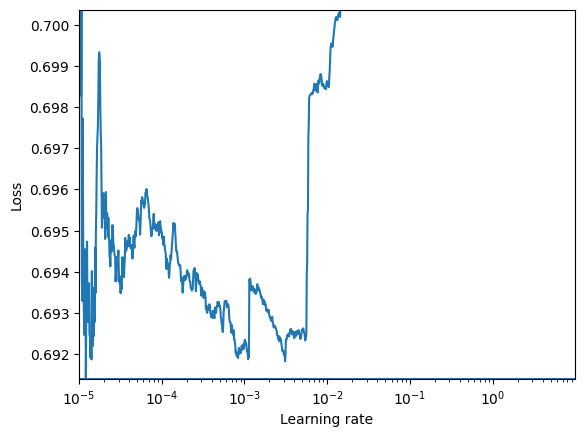

In [47]:
# plot_lr_vs_loss(rates, losses)

In [50]:
N_EPOCHS = 100
BATCH_SIZE = 256

# Build model.
ei_classifier = build_model()

# Instatiate callbacks to use for checkpointing progress, 1cycle learning rate scheduling and early stopping.
checkpoint = ModelCheckpoint("models/ei_classifier.h5", monitor="val_auc", save_best_only=True, mode="max")
# onecycle = OneCycleScheduler(math.ceil(len(X_train_EI / BATCH_SIZE)) * N_EPOCHS, max_rate=1e-03)
early_stopping = EarlyStopping("val_auc", patience=10, restore_best_weights=True, mode="max")

# Fit model to training data.
history = ei_classifier.fit(
    X_train_EI,
    y_train_EI,
    validation_data=(X_test_EI, y_test_EI),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=[early_stopping, checkpoint],
    class_weight=None
)

Epoch 1/100
1236/1236 [==============================] - 186s 146ms/step - loss: 0.5317 - auc: 0.2996 - accuracy: 0.7696 - val_loss: 0.5202 - val_auc: 0.3388 - val_accuracy: 0.7730
Epoch 2/100
1236/1236 [==============================] - 199s 161ms/step - loss: 0.5064 - auc: 0.3864 - accuracy: 0.7749 - val_loss: 0.5210 - val_auc: 0.3460 - val_accuracy: 0.7736
Epoch 3/100
1236/1236 [==============================] - 207s 167ms/step - loss: 0.4895 - auc: 0.4273 - accuracy: 0.7800 - val_loss: 0.5257 - val_auc: 0.3440 - val_accuracy: 0.7718
Epoch 4/100
1236/1236 [==============================] - 199s 161ms/step - loss: 0.4727 - auc: 0.4699 - accuracy: 0.7866 - val_loss: 0.5346 - val_auc: 0.3402 - val_accuracy: 0.7680
Epoch 5/100
 166/1236 [===>..........................] - ETA: 2:35 - loss: 0.4491 - auc: 0.5234 - accuracy: 0.7980

KeyboardInterrupt: 

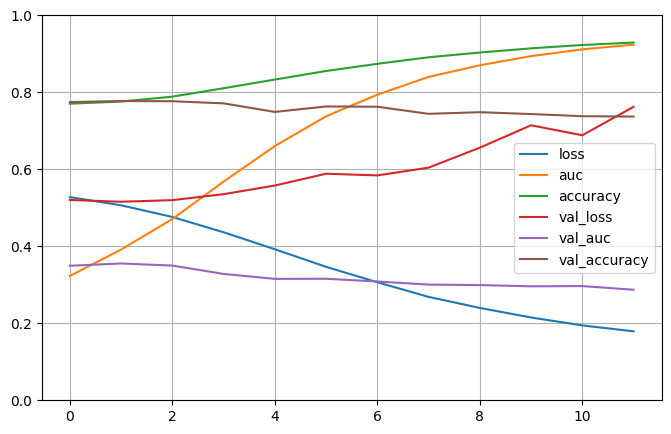

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [51]:
ei_classifier = load_model("models/ei_classifier.h5")
evaluate(X_test_EI, y_test_EI, ei_classifier)

3295/3295 [==============================] - 40s 12ms/step
              precision    recall  f1-score   support

           0       0.78      0.98      0.87     81302
           1       0.54      0.08      0.14     24138

    accuracy                           0.77    105440
   macro avg       0.66      0.53      0.51    105440
weighted avg       0.73      0.77      0.70    105440



##### Tune classifier for Extraversion vs Introversion

In [18]:
BATCH_SIZE = 32
N_EPOCHS = 100

tuner = keras_tuner.Hyperband(
    hypermodel=build_model_tuning,
    objective=keras_tuner.Objective("val_auc", direction="max"),
    directory="hyperparam search",
    project_name="ei_classifier",
    overwrite=False
)
checkpoint = ModelCheckpoint("models/ei_classifier_tuning.h5", monitor="val_auc", save_best_only=True, mode="max")
early_stopping = EarlyStopping("val_auc", patience=10, restore_best_weights=True, mode="max")

tuner.search(
    X_train_EI,
    y_train_EI,
    validation_data=(X_test_EI, y_test_EI),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=[early_stopping, checkpoint],
    class_weight=None
)

Trial 84 Complete [00h 12m 51s]
val_auc: 0.33701667189598083

Best val_auc So Far: 0.3496936559677124
Total elapsed time: 03h 11m 14s

Search: Running Trial #85

Value             |Best Value So Far |Hyperparameter
1                 |5                 |kernel_size_1
2                 |1                 |strides_1
elu               |relu              |activation_1
1                 |5                 |kernel_size_2
2                 |1                 |strides_2
relu              |elu               |activation_2
0.60737           |0.7231            |dropout_rate_1
7                 |1                 |kernel_size_3
1                 |1                 |strides_3
elu               |relu              |activation_3
9                 |3                 |kernel_size_4
2                 |2                 |strides_4
elu               |elu               |activation_4
0.059865          |0.55077           |dropout_rate_2
Adam              |Adam              |optimizer
2                 |2       

KeyboardInterrupt: 

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]